In [73]:
# ====================================================
# Library
# ====================================================
import sys
import os
import gc
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')
import random
import copy
import scipy as sp
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import joblib
import pickle
import itertools
from tqdm.auto import tqdm
import category_encoders as ce
import torch
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import Callback
from keras.models import clone_model
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',100)

# ====================================================
# Configurations
# ====================================================
class CFG:
    VER = 2
    AUTHOR = 'Naoki'
    COMPETITION = 'SC2024'
    DATA_PATH = Path('/data')
    OOF_DATA_PATH = Path('/oof')
    MODEL_DATA_PATH = Path('/models')
    SUB_DATA_PATH = Path('/submission')
    METHOD_LIST = ['catboost']
    seed = 42
    n_folds = 7
    target_col = 'ProdTaken'
    metric = 'AUC'
    metric_maximize_flag = True
    num_boost_round = 300
    early_stopping_round = 200
    verbose = 25
    classification_lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves' : 15,
        'lambda_l1' : 0.2,
        'lambda_l2' : 0.2,
        'seed': seed,
    }
    classification_xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.05,
        'lambda':2,
        'random_state': seed,
    }

    classification_cat_params = {
        'learning_rate': 0.1,
        'depth':1,
        'l2_leaf_reg' : 6,
        'iterations':1000,
        'random_seed': seed,
    }
    classification_adaboost_params = {
        'n_estimators': 100,
        'learning_rate': 1.0,
        'random_state': 42,
    }
    
    model_weight_dict = {'adaboost': 0.10,'lightgbm': 0.24, 'xgboost': 0.04, 'catboost': 0.72}
    
# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)


# ====================================================
# Metric
# ====================================================
# AUC

# ====================================================
# LightGBM Metric
# ====================================================
def lgb_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'f1score', f1_score(y_true, np.where(y_pred >= 0.5, 1, 0), average='macro'), CFG.metric_maximize_flag

# ====================================================
# XGBoost Metric
# ====================================================
def xgb_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'f1score', f1_score(y_true, np.where(y_pred >= 0.5, 1, 0), average='macro')

In [74]:
#データの読み込み
train_df = pd.read_csv('data/train_processed.csv', index_col=0)
test_df = pd.read_csv('data/test_processed.csv', index_col=0)

#学習に必要となるリストの作成
LabelList = ['TypeofContact','car_possesion','Passport','Gender','PitchSatisfactionScore']
OneHotList = ['CityTier','Occupation','ProductPitched','PreferredPropertyStar','Designation','married']
default_categorical_features = ['TypeofContact','car_possesion','Passport','Gender','PitchSatisfactionScore',
                                'CityTier','Occupation','ProductPitched','PreferredPropertyStar','Designation','married']
default_numerical_features = ['Age','DurationOfPitch','NumberOfPersonVisiting','NumberOfFollowups','NumberOfTrips',
                              'MonthlyIncome','offspring']
'''
NumericalList = ['Age','DurationOfPitch','NumberOfPersonVisiting','NumberOfFollowups','NumberOfTrips','MonthlyIncome','offspring',
               'family_members','Income_person','Child_Rate', 'MoneyforOneTrip','AllOfcontact','PitchPoint','Income_child']
'''
NumericalList = ['Age','DurationOfPitch','NumberOfPersonVisiting','NumberOfFollowups','NumberOfTrips','MonthlyIncome','offspring',
               'family_members','Income_person','Child_Rate', 'MoneyforOneTrip','AllOfcontact','PitchPoint','Income_child',
                'Income_Age']

def Preprocessing(train_df, test_df):
    
    def miss_dealing(train_df,test_df):
        #ラベルエンコーディング
        LabelList = ['TypeofContact','Occupation','ProductPitched','Designation','married']
        for col in LabelList:
            encoder = LabelEncoder()
            combined = pd.concat([train_df[col], test_df[col]], axis=0)
            encoder.fit(combined)
            train_df[col] = encoder.transform(train_df[col])
            test_df[col] = encoder.transform(test_df[col])
        features = ['Age','TypeofContact','CityTier','DurationOfPitch','Occupation','Gender','NumberOfPersonVisiting','NumberOfFollowups',
                    'ProductPitched','PreferredPropertyStar','NumberOfTrips','Passport','PitchSatisfactionScore','Designation',
                    'MonthlyIncome','married','car_possesion','offspring']
        train_x = train_df[features]
        imputer = IterativeImputer(max_iter=10, random_state=0)
        imputer.fit(train_x)
        train_x_imputed = imputer.transform(train_x)
        train_df_imputed = pd.DataFrame(train_x_imputed, columns=train_x.columns)
        train_df_imputed[CFG.target_col] = train_df[CFG.target_col]
        test_df_imputed = imputer.transform(test_df)
        test_df_imputed = pd.DataFrame(test_df_imputed, columns=test_df.columns)
        original_index = list(range(3489,6978))
        test_df_imputed.index = original_index
        return train_df_imputed,test_df_imputed
    
     #特徴量作成
    def make_features(input_df):
        df = input_df.copy()
        def count_adult_members(input_str):
            if input_str == 1.0:
                return 2
            else:
                return 1
        
        print(train_df)
        df['family_members'] = df['married'].apply(count_adult_members) + df['offspring']
        df['Child_Rate'] = df['offspring']/df['family_members']
        df['Income_person'] = df['MonthlyIncome']/df['family_members']
        df['Income_child'] =  df['MonthlyIncome']/(df['offspring']+0.0001)
        df['MoneyforOneTrip'] = df['MonthlyIncome']*12/df['NumberOfTrips']
        df['AllOfcontact'] = df['DurationOfPitch'] + df['NumberOfFollowups']*2.1
        df['PitchPoint'] = df['DurationOfPitch'] * df['PitchSatisfactionScore']
        df['Income_Age'] = df['MonthlyIncome'] / df['Age']
        df['Passport_NoCar_Single'] = (df['Passport'] *(1- df['car_possesion']) * df['married'] == 2.0).astype(int)
        

            


        
        return df
    
    

    def encoding(train_df,test_df):
        #ラベルエンコーディング
        for col in LabelList:
            encoder = LabelEncoder()
            combined = pd.concat([train_df[col], test_df[col]], axis=0)
            encoder.fit(combined)
            train_df[col] = encoder.transform(train_df[col])
            test_df[col] = encoder.transform(test_df[col])
        #ワンホットエンコーディング
        train_df2 = train_df.drop([CFG.target_col],axis=1)
        ohe = ce.OneHotEncoder(cols=OneHotList,use_cat_names=True)
        train_df2 = ohe.fit_transform(train_df2)
        test_df = ohe.transform(test_df)
        train_df = pd.concat([train_df2,train_df[CFG.target_col]],axis=1)
        return train_df, test_df
        
    train_df, test_df = miss_dealing(train_df, test_df)
    train_df = make_features(train_df)
    test_df = make_features(test_df)
    print(train_df)
    train_df.info()
    train_df, test_df = encoding(train_df, test_df)
    return train_df, test_df
    
#前処理の実行
train_df, test_df = Preprocessing(train_df,test_df)



#特徴量の指定
features = train_df.columns.tolist()
#学習に使用しない特徴量は以下で除外
RemoveList=[CFG.target_col]
for i in RemoveList:
    features.remove(i)
print(f'features for training:{features}')

#カテゴリカル特徴量の指定
categorical_features = copy.deepcopy(features)
print(NumericalList)
for i in NumericalList:
    categorical_features.remove(i)
print(categorical_features)




            Age  TypeofContact  CityTier  DurationOfPitch  Occupation  Gender  \
0     50.000000            1.0       2.0             15.0         0.0     0.0   
1     56.000000            0.0       1.0             14.0         1.0     0.0   
2     35.814031            1.0       1.0             10.0         0.0     1.0   
3     37.000000            1.0       2.0             18.0         2.0     1.0   
4     48.000000            0.0       3.0             17.0         2.0     1.0   
...         ...            ...       ...              ...         ...     ...   
3484  40.000000            1.0       2.0             26.0         1.0     0.0   
3485  40.000000            1.0       1.0              9.0         0.0     0.0   
3486  31.000000            1.0       1.0             14.0         2.0     1.0   
3487  56.000000            0.0       2.0             15.0         1.0     0.0   
3488  42.000000            1.0       1.0              9.0         2.0     0.0   

      NumberOfPersonVisitin

features for training:['Age', 'TypeofContact', 'CityTier_2.0', 'CityTier_1.0', 'CityTier_3.0', 'DurationOfPitch', 'Occupation_0.0', 'Occupation_1.0', 'Occupation_2.0', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched_0.0', 'ProductPitched_3.0', 'ProductPitched_4.0', 'ProductPitched_1.0', 'ProductPitched_2.0', 'PreferredPropertyStar_3.0', 'PreferredPropertyStar_4.0', 'PreferredPropertyStar_5.0', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation_1.0', 'Designation_3.0', 'Designation_0.0', 'Designation_2.0', 'Designation_4.0', 'MonthlyIncome', 'married_3.0', 'married_0.0', 'married_1.0', 'married_2.0', 'car_possesion', 'offspring', 'family_members', 'Child_Rate', 'Income_person', 'Income_child', 'MoneyforOneTrip', 'AllOfcontact', 'PitchPoint', 'Income_Age', 'Passport_NoCar_Single']
['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome', 'offspring', 'family_members', 'Income_person', 'Child_Rate'

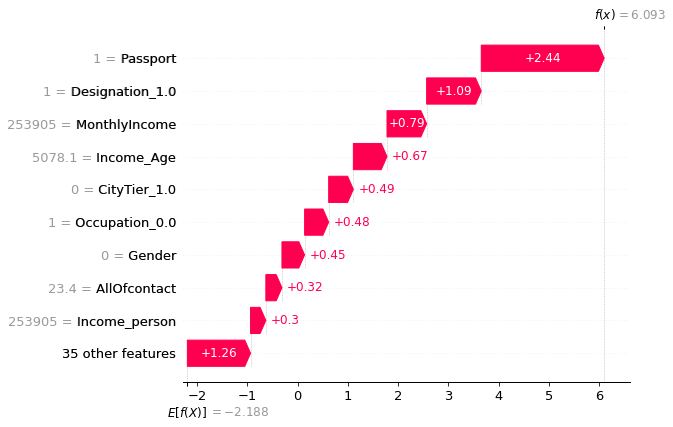

In [75]:
model = xgb.XGBClassifier(eval_metric = 'auc')
model.fit(train_df[features],train_df[CFG.target_col])
explainer = shap.Explainer(model)
shap_values = explainer(train_df[features])
shap.plots.waterfall(shap_values[0])

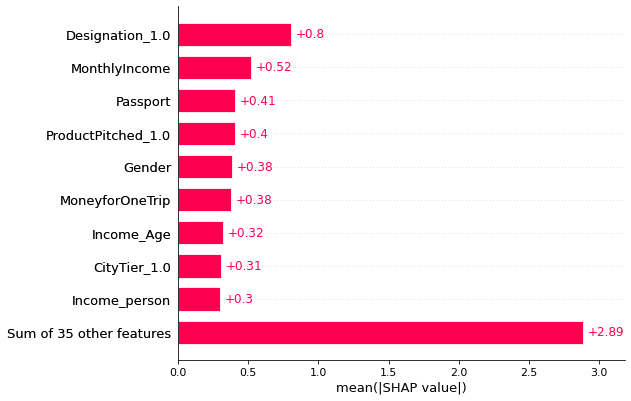

In [76]:
shap.plots.bar(shap_values)

In [77]:
#Learning & Predicting

#1段階目の学習
def Pre_Learning(train_df,test_df, features, categorical_features):
    
    #adaboostでの学習メソッドの定義
    def adaboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        model = AdaBoostClassifier(**CFG.classification_adaboost_params)
        model.fit(x_train, y_train)
        # Predict validation
        valid_pred = model.predict_proba(x_valid)[:, 1]
        return model, valid_pred

    #lightgbmでの学習メソッドの定義
    def lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
        lgb_valid = lgb.Dataset(x_valid, y_valid, categorical_feature=categorical_features)
        model = lgb.train(
                    params = CFG.classification_lgb_params,
                    train_set = lgb_train,
                    num_boost_round = CFG.num_boost_round,
                    valid_sets = [lgb_train, lgb_valid],
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.early_stopping_round,
                                                  verbose=CFG.verbose)]
                )
        # Predict validation
        valid_pred = model.predict(x_valid)
        return model, valid_pred

    #xgboostでの学習メソッドの定義
    def xgboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        xgb_train = xgb.DMatrix(data=x_train, label=y_train)
        xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid)
        model = xgb.train(
                    CFG.classification_xgb_params,
                    dtrain = xgb_train,
                    num_boost_round = CFG.num_boost_round,
                    evals = [(xgb_train, 'train'), (xgb_valid, 'eval')],
                    early_stopping_rounds = CFG.early_stopping_round,
                    verbose_eval = CFG.verbose,
                    maximize = CFG.metric_maximize_flag,
                )
        # Predict validation
        valid_pred = model.predict(xgb.DMatrix(x_valid))
        return model, valid_pred

    #catboostでの学習メソッドの定義
    def catboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features):
        cat_train = Pool(data=x_train, label=y_train, cat_features=categorical_features)
        cat_valid = Pool(data=x_valid, label=y_valid, cat_features=categorical_features)
        model = CatBoostClassifier(**CFG.classification_cat_params)
        model.fit(cat_train,
                  eval_set = [cat_valid],
                  early_stopping_rounds = CFG.early_stopping_round,
                  verbose = CFG.verbose,
                  use_best_model = True)
        # Predict validation
        valid_pred = model.predict_proba(x_valid)[:, 1]
        return model, valid_pred



    #任意のモデルでのクロスバリデーション学習メソッドの定義
    def gradient_boosting_model_cv_training(method, train_df, features, categorical_features):
        # Create a numpy array to store out of folds predictions
        oof_predictions = np.zeros(len(train_df))
        oof_fold = np.zeros(len(train_df))
        kfold = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
        for fold, (train_index, valid_index) in enumerate(kfold.split(train_df[features],train_df[CFG.target_col])):
            print('-'*50)
            print(f'{method} training fold {fold+1}')

            x_train = train_df[features].iloc[train_index]
            y_train = train_df[CFG.target_col].iloc[train_index]
            x_valid = train_df[features].iloc[valid_index]
            y_valid = train_df[CFG.target_col].iloc[valid_index]

            model = None  # モデル変数を初期化する
            valid_pred = None

            if method == 'adaboost':
                model, valid_pred = adaboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'lightgbm':
                model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'xgboost':
                model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
            if method == 'catboost':
                model, valid_pred = catboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)  
            # Save best model
            pickle.dump(model, open(f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'wb'))
            # Add to out of folds array
            oof_predictions[valid_index] = valid_pred
            oof_fold[valid_index] = fold + 1
            del x_train, x_valid, y_train, y_valid, model, valid_pred
            gc.collect()

        # Compute out of folds metric
        #score = f1_score(train_df[CFG.target_col], oof_predictions >= 0.5, average='macro')
        score = roc_auc_score(train_df[CFG.target_col], oof_predictions)
        print(f'{method} our out of folds CV AUC is {score}')
        # Create a dataframe to store out of folds predictions
        oof_df = pd.DataFrame({CFG.target_col: train_df[CFG.target_col], f'{method}_prediction': oof_predictions, 'fold': oof_fold})
        oof_df.to_csv(f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv', index = False)

    #adaboostの学習済みモデル読み込み関数
    def adaboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'adaboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict_proba(x_test)[:, 1]
            test_pred += pred
        return test_pred / CFG.n_folds

    #lightgbmの学習モデル読み込み関数
    def lightgbm_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict(x_test)
            test_pred += pred
        return test_pred / CFG.n_folds

    #xgboostの学習モデル読み込み関数
    def xgboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict(xgb.DMatrix(x_test))
            test_pred += pred
        return test_pred / CFG.n_folds

    #catboostの学習モデル読み込み関数
    def catboost_inference(x_test):
        test_pred = np.zeros(len(x_test))
        for fold in range(CFG.n_folds):
            model = pickle.load(open(f'catboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
            # Predict
            pred = model.predict_proba(x_test)[:, 1]
            test_pred += pred
        return test_pred / CFG.n_folds

    #任意のメソッドに対して予測を返す関数
    def gradient_boosting_model_inference(method, test_df, features, categorical_features):
        x_test = test_df[features]
        if method == 'adaboost':
            test_pred = adaboost_inference(x_test)
        if method == 'lightgbm':
            test_pred = lightgbm_inference(x_test)
        if method == 'xgboost':
            test_pred = xgboost_inference(x_test)
        if method == 'catboost':
            test_pred = catboost_inference(x_test)
        return test_pred

    for method in CFG.METHOD_LIST:
        gradient_boosting_model_cv_training(method, train_df, features, categorical_features)
        test_df[f'{method}_pred_prob'] = gradient_boosting_model_inference(method, test_df, features, categorical_features)
        
        

Pre_Learning(train_df,test_df, features, categorical_features)

--------------------------------------------------
catboost training fold 1
0:	learn: 0.6233963	test: 0.6228586	best: 0.6228586 (0)	total: 9.64ms	remaining: 9.63s
25:	learn: 0.3353391	test: 0.3344200	best: 0.3344200 (25)	total: 377ms	remaining: 14.1s
50:	learn: 0.3187728	test: 0.3192274	best: 0.3192274 (50)	total: 747ms	remaining: 13.9s
75:	learn: 0.3096472	test: 0.3110647	best: 0.3110188 (74)	total: 1.11s	remaining: 13.5s
100:	learn: 0.3050811	test: 0.3074521	best: 0.3074521 (100)	total: 1.48s	remaining: 13.2s
125:	learn: 0.3017229	test: 0.3058954	best: 0.3058165 (123)	total: 1.87s	remaining: 13s
150:	learn: 0.2983440	test: 0.3012892	best: 0.3012635 (149)	total: 2.25s	remaining: 12.7s
175:	learn: 0.2957503	test: 0.2999435	best: 0.2996004 (172)	total: 2.64s	remaining: 12.3s
200:	learn: 0.2938909	test: 0.2989319	best: 0.2989319 (200)	total: 3.01s	remaining: 12s
225:	learn: 0.2923082	test: 0.2977603	best: 0.2976537 (221)	total: 3.38s	remaining: 11.6s
250:	learn: 0.2904610	test: 0.2970766

150:	learn: 0.2959733	test: 0.3032337	best: 0.3032337 (150)	total: 2.27s	remaining: 12.8s
175:	learn: 0.2937768	test: 0.3028259	best: 0.3026340 (158)	total: 2.66s	remaining: 12.4s
200:	learn: 0.2915950	test: 0.3025308	best: 0.3022047 (180)	total: 3.04s	remaining: 12.1s
225:	learn: 0.2898143	test: 0.3030475	best: 0.3022047 (180)	total: 3.44s	remaining: 11.8s
250:	learn: 0.2888086	test: 0.3028405	best: 0.3022047 (180)	total: 3.82s	remaining: 11.4s
275:	learn: 0.2875270	test: 0.3033824	best: 0.3022047 (180)	total: 4.21s	remaining: 11s
300:	learn: 0.2865623	test: 0.3035295	best: 0.3022047 (180)	total: 4.58s	remaining: 10.6s
325:	learn: 0.2856582	test: 0.3032071	best: 0.3022047 (180)	total: 4.99s	remaining: 10.3s
350:	learn: 0.2843593	test: 0.3034470	best: 0.3022047 (180)	total: 5.36s	remaining: 9.92s
375:	learn: 0.2835212	test: 0.3033243	best: 0.3022047 (180)	total: 5.73s	remaining: 9.51s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3022047396
bestIteration = 180

S

625:	learn: 0.2835312	test: 0.2691368	best: 0.2686846 (598)	total: 9.91s	remaining: 5.92s
650:	learn: 0.2830865	test: 0.2692058	best: 0.2686846 (598)	total: 10.3s	remaining: 5.52s
675:	learn: 0.2825462	test: 0.2689995	best: 0.2686846 (598)	total: 10.7s	remaining: 5.11s
700:	learn: 0.2820250	test: 0.2688870	best: 0.2686846 (598)	total: 11.1s	remaining: 4.73s
725:	learn: 0.2815521	test: 0.2691843	best: 0.2686846 (598)	total: 11.6s	remaining: 4.36s
750:	learn: 0.2811125	test: 0.2695591	best: 0.2686846 (598)	total: 12s	remaining: 3.98s
775:	learn: 0.2806861	test: 0.2696853	best: 0.2686846 (598)	total: 12.5s	remaining: 3.59s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2686845561
bestIteration = 598

Shrink model to first 599 iterations.
--------------------------------------------------
catboost training fold 7
0:	learn: 0.6141150	test: 0.6139599	best: 0.6139599 (0)	total: 9.66ms	remaining: 9.65s
25:	learn: 0.3323610	test: 0.3466370	best: 0.3466370 (25)	total: 407ms

In [78]:
test_df['target'] = 0
for method in CFG.METHOD_LIST:
    test_df['target'] += test_df[f'{method}_pred_prob']*CFG.model_weight_dict[method]
    
test_df['target'].to_csv(f'seed{CFG.seed}_ver{CFG.VER}_{CFG.AUTHOR}_submission.csv', header=False)

In [79]:
model = pickle.load(open(f'catboost_fold1_seed42_ver{CFG.VER}.pkl', 'rb'))
feature_importances = model.get_feature_importance()
feature_importances_df = pd.DataFrame({
    'Feature':train_df[features].columns,
    'Importance': feature_importances}).sort_values(by = 'Importance',ascending=False)
print(feature_importances_df)

non_zero_feature_importances_df = feature_importances_df[feature_importances_df['Importance']>0.0]
non_zero_feature_importances_df_list = non_zero_feature_importances_df['Feature'].tolist()
print(len(non_zero_feature_importances_df_list),non_zero_feature_importances_df_list)

                      Feature  Importance
23            Designation_1.0   17.235548
21                   Passport    8.764943
32                married_2.0    8.117654
28              MonthlyIncome    7.551134
15         ProductPitched_1.0    6.918257
12         ProductPitched_0.0    6.109100
40               AllOfcontact    5.282574
9                      Gender    5.208263
0                         Age    4.592518
3                CityTier_1.0    3.662960
39            MoneyforOneTrip    3.524532
37              Income_person    3.183567
26            Designation_2.0    2.991112
5             DurationOfPitch    2.953424
41                 PitchPoint    1.991352
42                 Income_Age    1.640222
1               TypeofContact    1.637464
20              NumberOfTrips    1.494836
22     PitchSatisfactionScore    1.434805
11          NumberOfFollowups    1.292580
38               Income_child    1.179658
18  PreferredPropertyStar_4.0    0.890986
33              car_possesion    0

#2段階目の学習　ニューラルネットワークによるスタッキング
def Post_Learning(train_df,test_df):
    #ニューラルネットワークモデル作成関数
    def create_nn_model(input_shape):
        model = Sequential([
            Dense(64, input_shape=(input_shape,)),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.5),

            Dense(32),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.5),

            Dense(1, activation='sigmoid')
        ])
        optimizer = Adam(lr=0.001)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    #ニューラルネットワーク用学習スケジューラー
    def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * np.exp(-0.1)

    #特徴量同士で積を作る関数
    def create_interaction_features(features):
            n_features = features.shape[1]
            interaction_features = []
            for i in range(n_features):
                for j in range(i + 1, n_features):
                    interaction_features.append(features[:, i] * features[:, j])  
            return np.column_stack(interaction_features)
    
    # OOF予測を基に新たな特徴量を作成
    oof_features = np.zeros((train_df.shape[0], len(CFG.METHOD_LIST)))
    for i, method in enumerate(CFG.METHOD_LIST):
        oof_df = pd.read_csv(f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv')
        oof_features[:, i] = oof_df[f'{method}_prediction']
    
    # テストデータの予測を基に特徴量を作成
    test_features = np.zeros((test_df.shape[0], len(CFG.METHOD_LIST)))
    for i, method in enumerate(CFG.METHOD_LIST):
        test_features[:, i] = test_df[f'{method}_pred_prob']

    # 特徴量同士の積を追加
    oof_interaction_features = create_interaction_features(oof_features)
    test_interaction_features = create_interaction_features(test_features)

    # 元の特徴量と相互作用特徴量を組み合わせ
    oof_combined_features = np.hstack([oof_features, oof_interaction_features])
    test_combined_features = np.hstack([test_features, test_interaction_features])

    # 特徴量の標準化
    scaler = StandardScaler()
    oof_combined_features_scaled = scaler.fit_transform(oof_combined_features)
    test_combined_features_scaled = scaler.transform(test_combined_features)   
    
    # ニューラルネットワークモデルを学習
    nn_model = create_nn_model(oof_combined_features_scaled.shape[1])
    callbacks_list = [LearningRateScheduler(scheduler)]
    nn_model.fit(oof_combined_features_scaled, train_df[CFG.target_col],
                 validation_split=0.2, epochs=50, batch_size=32, callbacks=callbacks_list, verbose=1)
    nn_model.save(f'nn_stacking_model_seed{CFG.seed}_ver{CFG.VER}.h5')
    
    #ロジスティック回帰モデルを学習
    lr_model = LogisticRegression()
    lr_model.fit(oof_combined_features_scaled, train_df[CFG.target_col])
    pickle.dump(lr_model, open(f'lr_stacking_model_seed{CFG.seed}_ver{CFG.VER}.pkl','wb'))
    

def Learning_and_Predicting(train_df, test_df, features, categorical_features):
    Pre_Learning(train_df, test_df, features, categorical_features)
    Post_Learning(train_df, test_df)

#学習の実行
Learning_and_Predicting(train_df, test_df, features, categorical_features)

#Postprocessing

def Postprocessing():
    
    # ニューラルネットワークモデルの学習データに対する予測確率
    nn_model = load_model(f'nn_stacking_model_seed{CFG.seed}_ver{CFG.VER}.h5')
    train_pred_proba_nn = nn_model.predict(train_df,oof_combined_features_scaled).flatten()
    
    # テストデータに対する最終予測
    test_pred_proba_nn = nn_model.predict(test_combined_features_scaled).flatten()
    
    # 最終予測結果をコンペ提出用のフォーマットでCSVファイルに出力
    submission_df_nn = pd.DataFrame({'Id': test_df.index, 'target': test_final_predictions_nn}).reset_index(drop=True)
    submission_df_nn['Id'] = submission_df_nn.index + 4230
    submission_df_nn.to_csv(f'stacking_nn_submission_best_score{best_score_nn:.4f}_seed{CFG.seed}_ver{CFG.VER}_{CFG.AUTHOR}.csv', header=False, index=False)
    
    
    # ロジスティック回帰モデルの学習データに対する予測確率
    lr_model = pickle.load(open(f'lr_stacking_model_seed{CFG.seed}_ver{CFG.VER}.pkl','rb'))
    train_pred_proba_lr = lr_model.predict_proba(oof_combined_features_scaled)[:, 1]
    
    # テストデータに対する最終予測
    test_pred_proba_lr = lr_model.predict_proba(test_combined_features_scaled)[:, 1]

    # 最終予測結果をコンペ提出用のフォーマットでCSVファイルに出力
    submission_df_lr = pd.DataFrame({'Id': test_df.index, 'target': test_final_predictions_lr}).reset_index(drop=True)
    submission_df_lr['Id'] = submission_df_lr.index + 4230
    submission_df_lr.to_csv(f'stacking_lr_submission_best_score{best_score_lr:.4f}_seed{CFG.seed}_ver{CFG.VER}_{CFG.AUTHOR}.csv', header=False, index=False)